# Chapter 10 – Introduction to Artificial Neural Networks with Keras

## Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires scikit-learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `"images/ann"` folder (if it doesn't already exist), and define the `save_fig()` function which is used throughout this notebook to save the figures in high-res for the book:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## From Biological to Artificial Neurons

### The Perceptron

In [6]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

In [7]:
iris = load_iris(as_frame=True)
type(iris)

sklearn.utils._bunch.Bunch

In [8]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [9]:
iris['data']

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [10]:
iris['target']

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int64

In [11]:
iris['target'].value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

In [12]:
iris['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [13]:
X = iris['data'][['petal length (cm)', 'petal width (cm)']].values
X.shape

(150, 2)

In [14]:
X[:5]

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2]])

In [15]:
y = (iris['target'] == 0) # 'setosa'
y.shape

(150,)

In [16]:
y[:5]

0    True
1    True
2    True
3    True
4    True
Name: target, dtype: bool

In [17]:
y.value_counts()

target
False    100
True      50
Name: count, dtype: int64

In [18]:
per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

Perceptron(random_state=42)

In [19]:
per_clf.coef_

array([[-1.4, -2.2]])

In [20]:
per_clf.intercept_

array([4.])

In [21]:
X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)
y_pred

array([ True, False])

The `Perceptron` is equivalent to an `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [22]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None, learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)

SGDClassifier(eta0=1, learning_rate='constant', loss='perceptron', penalty=None,
              random_state=42)

**Note:** This means that a perceptron can be trained using SGD, provided we know the loss function. Hebbian learning isn't the only way to train it.

In [23]:
sgd_clf.coef_

array([[-1.4, -2.2]])

In [24]:
sgd_clf.intercept_

array([4.])

In [25]:
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

When the Perceptron finds a decision boundary that properly separates the classes, it stops learning. This means that the decision boundary is often quite close to one class:

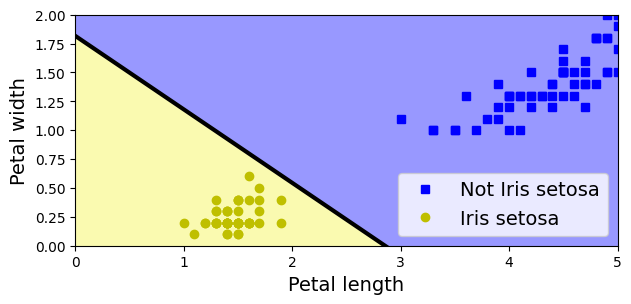

In [26]:
# Decision boundary of a Perceptron on the Iris dataset:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

### The Multilayer Perceptron and Backpropagation

**Activation functions**

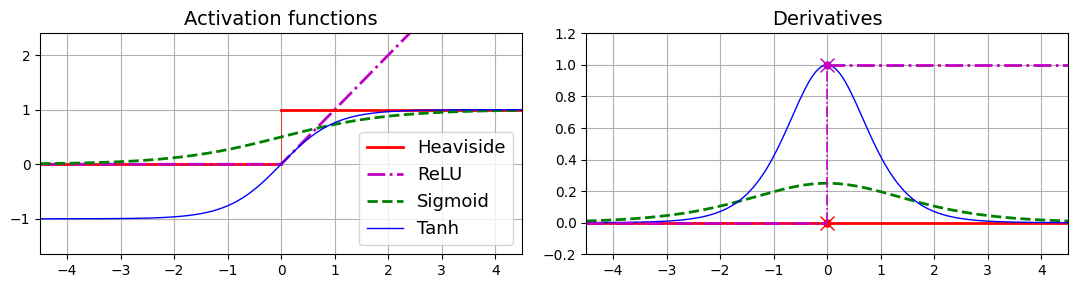

In [27]:
from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

**Note:** The derivatives of sigmoid and tanh both resemble normal distributions. The derivative of sigmoid is flatter, whereas the derivative of tanh is taller. (Let's not use the word '*kurtosis*' in this context, because these derivatives aren't frequency / probability distributions.)

### Regression MLPs

In [28]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [29]:
housing = fetch_california_housing()
type(housing)

sklearn.utils._bunch.Bunch

In [30]:
housing.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [31]:
housing['data']

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]])

In [32]:
housing['data'].shape

(20640, 8)

In [33]:
housing['feature_names']

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [34]:
housing['target']

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [35]:
housing['target'].shape

(20640,)

In [36]:
housing['target_names']

['MedHouseVal']

In [37]:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing['data'], housing['target'], random_state=42)
X_train_full.shape, X_test.shape, y_train_full.shape, y_test.shape

((15480, 8), (5160, 8), (15480,), (5160,))

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((11610, 8), (3870, 8), (11610,), (3870,))

In [39]:
mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
mlp_reg

MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)

**Note:** We're not having to specify the number of input units or the number of output units. (It's probably inferred automatically from the data when `fit` is called.)

From the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html" target="_blank">documentation</a> of `StandardScaler`:

> Standardize features by removing the mean and scaling to unit variance.

> The standard score of a sample x is calculated as:

> z = (x - u) / s

> where u is the mean of the training samples or zero if `with_mean=False`, and s is the standard deviation of the training samples or one if `with_std=False`.

In [40]:
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=[50, 50, 50],
                              random_state=42))])

**Note:** This fits both the `StandardScaler` and the `MLPRegressor` on the training set.

In [41]:
y_pred = pipeline.predict(X_valid)
y_pred.shape

(3870,)

**Note:** This first scales the features in the validation set (using the means & standard deviations learned from the training set), and then runs inference.

From the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html" target="_blank">documentation</a> of `mean_squared_error`:

> **squared : *bool, default=True***

> If `True` returns MSE value, if `False` returns RMSE value.

In [42]:
rmse = mean_squared_error(y_valid, y_pred, squared=False)
rmse

0.5053326657968679

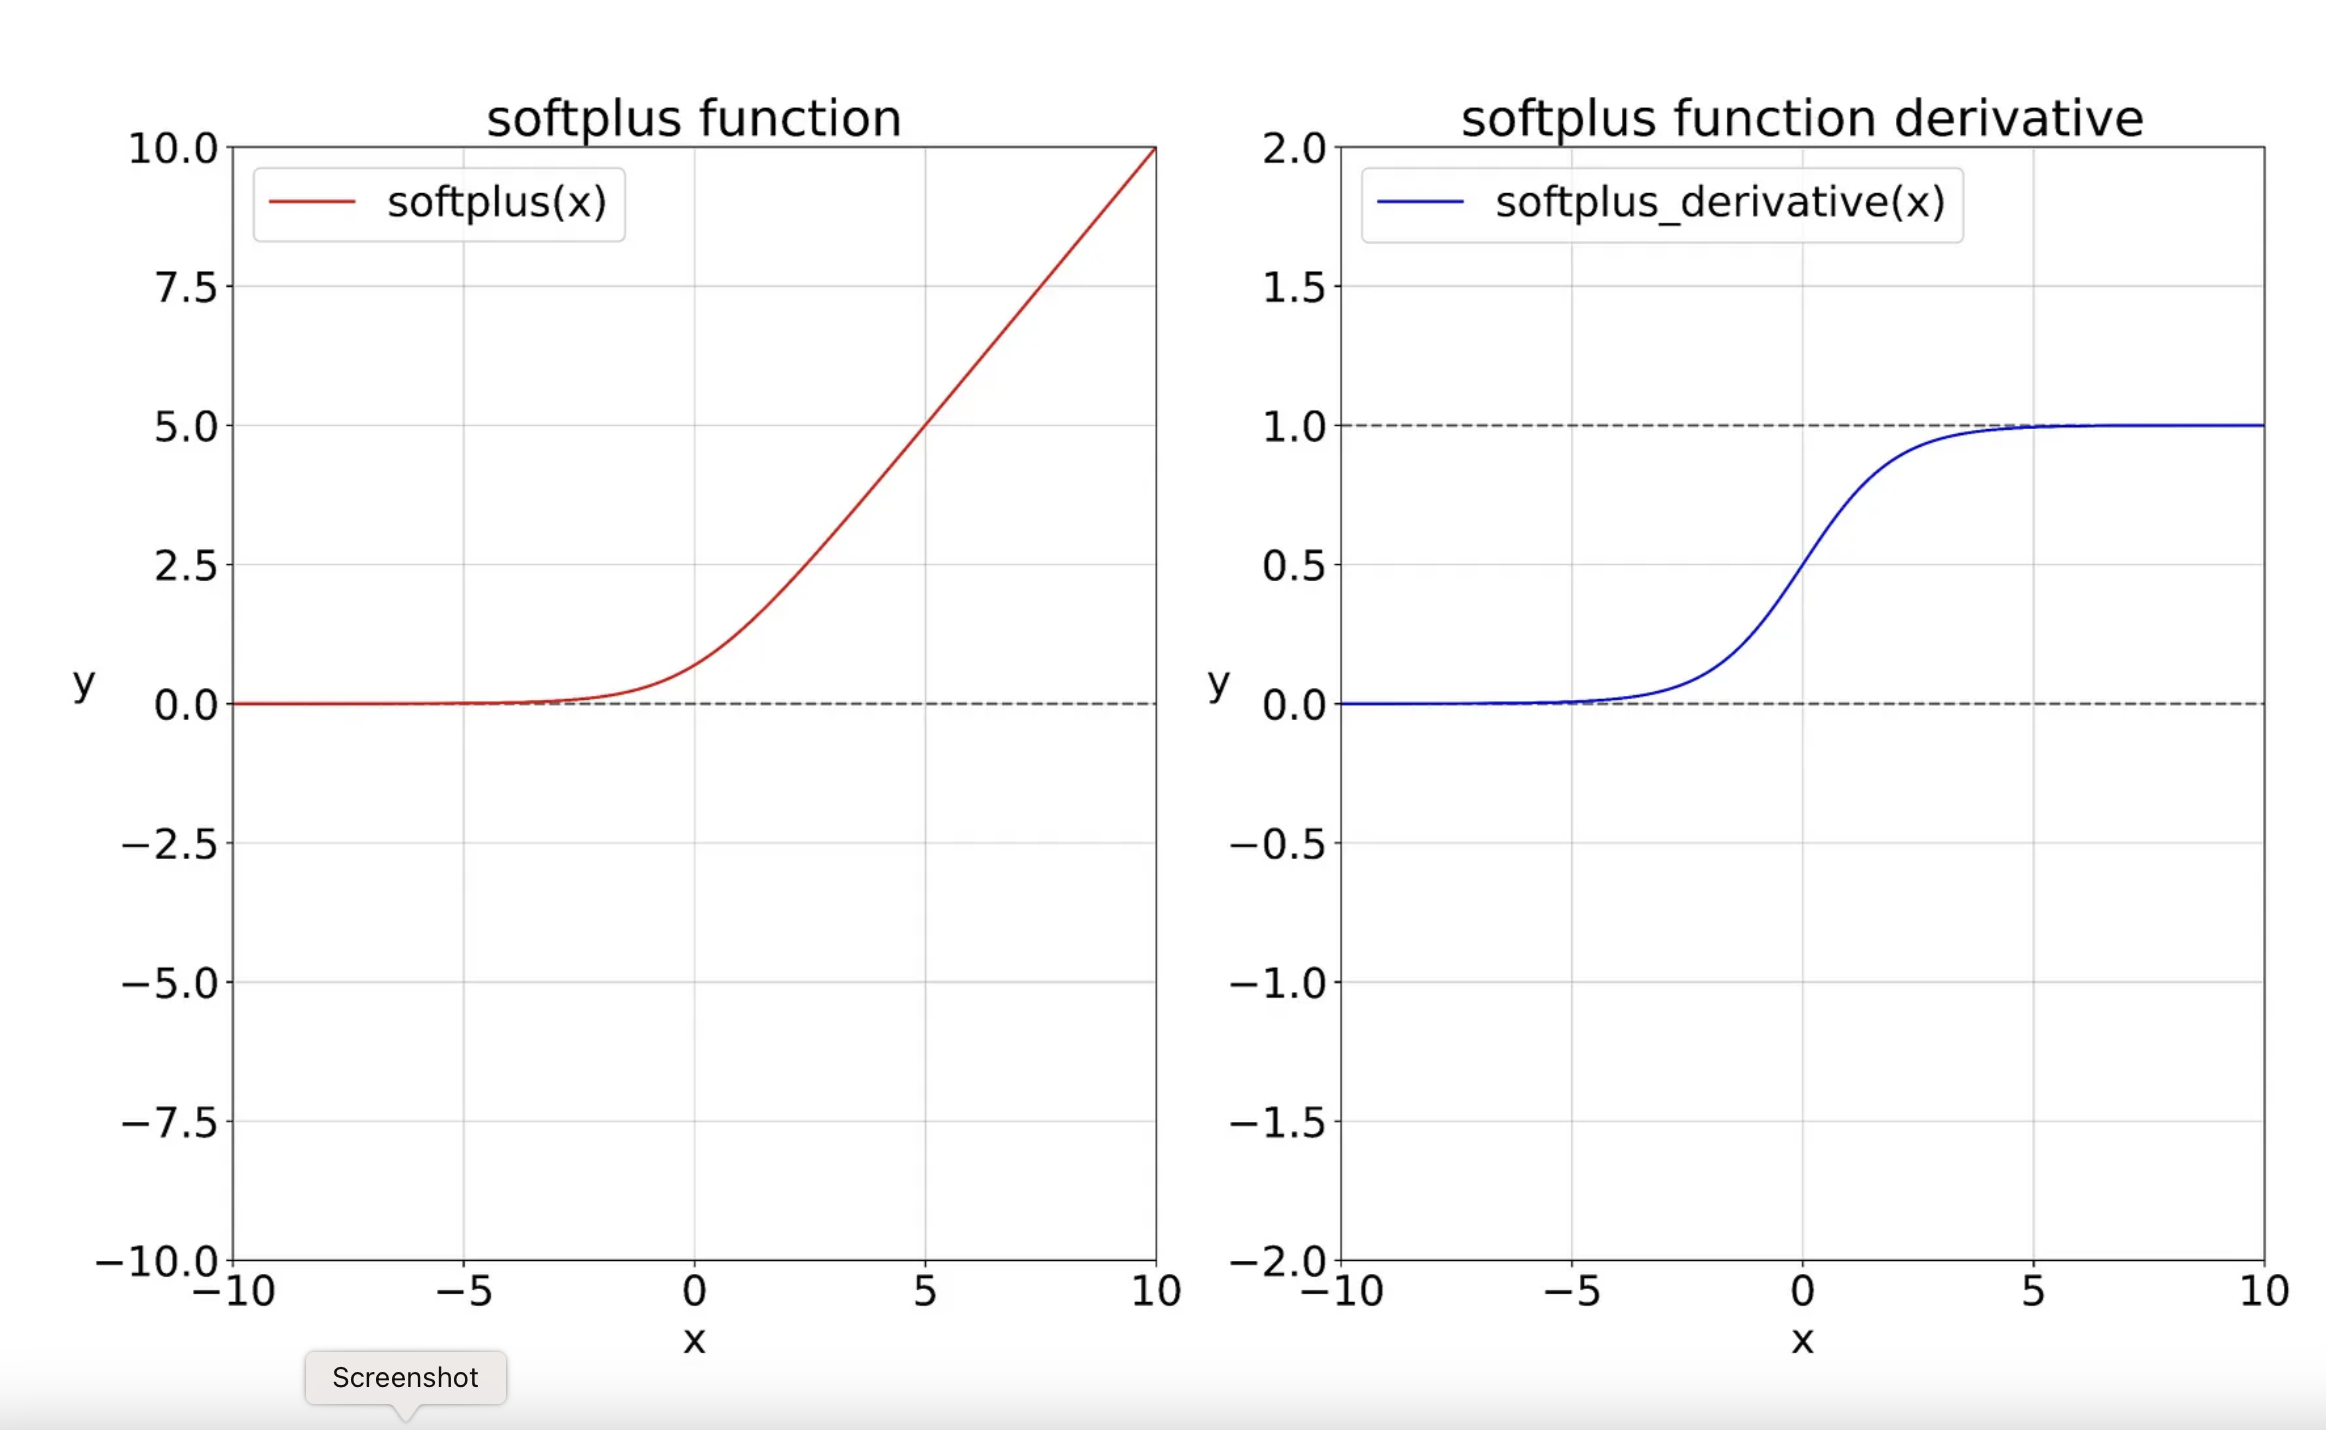

**Note:** The derivative of softplus is sigmoid.

### Classification MLPs

Mathematical formula for categorical cross-entropy:

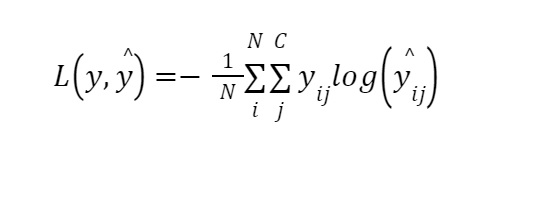

In [43]:
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier

iris = load_iris() # `as_frame=False` is the default.
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [44]:
iris['data'][:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [45]:
iris['target'][:5]

array([0, 0, 0, 0, 0])

In [46]:
X_train_full, X_test, y_train_full, y_test = train_test_split(iris['data'], iris['target'], test_size=0.1, random_state=42)
X_train_full.shape, X_test.shape, y_train_full.shape, y_test.shape

((135, 4), (15, 4), (135,), (15,))

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((121, 4), (14, 4), (121,), (14,))

In [48]:
mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000, random_state=42)
mlp_clf

MLPClassifier(hidden_layer_sizes=[5], max_iter=10000, random_state=42)

**Note:** We're not having to specify the number of input units or the number of output units. (It's probably inferred automatically from the data when `fit` is called.)

In [49]:
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=[5], max_iter=10000,
                               random_state=42))])

In [50]:
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

In [51]:
preds = pipeline.predict(X_valid)
preds.shape

(14,)

In [52]:
preds

array([2, 0, 1, 0, 0, 1, 2, 1, 1, 2, 1, 1, 1, 2])

In [53]:
proba = pipeline.predict_proba(X_valid)
proba.shape

(14, 3)

These are the softmax probabilities.

In [54]:
proba[0]

array([0.00325237, 0.0367113 , 0.96003633])

## Implementing MLPs with Keras

### Building an Image Classifier Using the Sequential API

#### Using Keras to load the dataset

Let's start by loading the Fashion MNIST dataset. Keras has a number of functions to load popular datasets in `tf.keras.datasets`. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [55]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
type(fashion_mnist)

4422102/4422102 [==============================] - 1s 0us/step


tuple

In [56]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
type(X_train_full), type(y_train_full), type(X_test), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [57]:
X_train_full.shape, y_train_full.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [58]:
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((55000, 28, 28), (55000,), (5000, 28, 28), (5000,))

Each pixel intensity is represented as a single byte (0 to 255):

In [59]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0 - 1 range and convert them to floats, by dividing by 255.0:

In [60]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.
X_train.dtype, X_valid.dtype, X_test.dtype

(dtype('float64'), dtype('float64'), dtype('float64'))

**Note:** As we've seen before (in other notebooks), NumPy's default float type is `float64`. In contrast, PyTorch's default float type is `float32`.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'` color map:

In [61]:
X_train[0].shape

(28, 28)

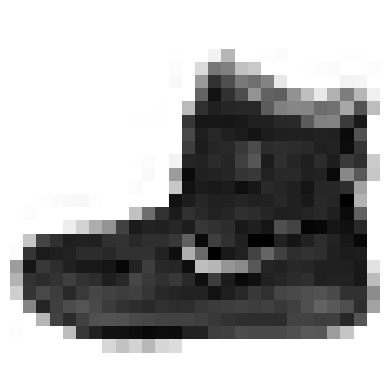

In [62]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

The labels are the class IDs (represented as `uint8`), from 0 to 9:

In [63]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [64]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

The first image in the training set is an ankle boot:

In [65]:
y_train[0]

9

In [66]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

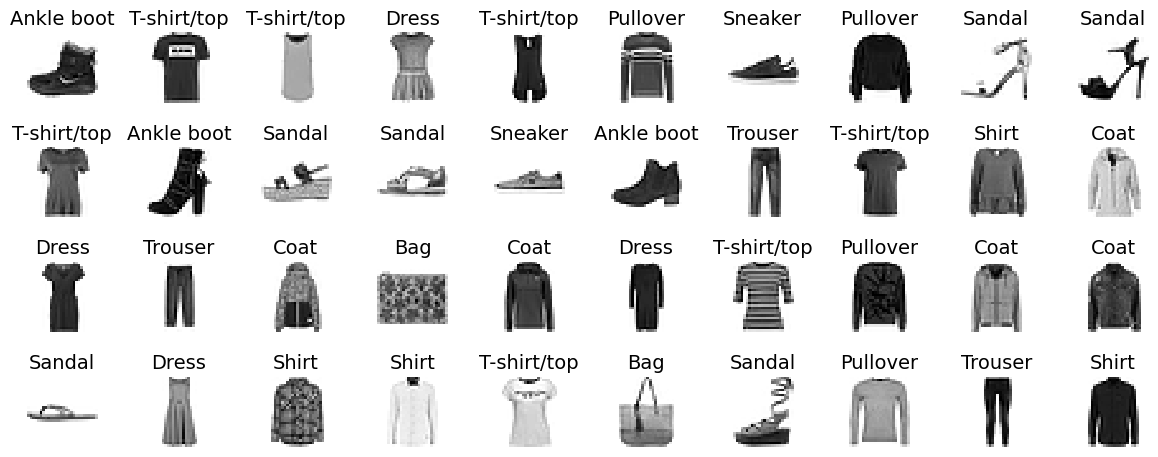

In [67]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

**Note:** Shirts, pullovers and coats look quite similar. This dataset is definitely more challenging that MNIST.

#### Creating the model using the Sequential API

In [68]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [69]:
tf.keras.backend.clear_session() # Clear the session to reset the name counters.
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Another way to display the model's architecture:

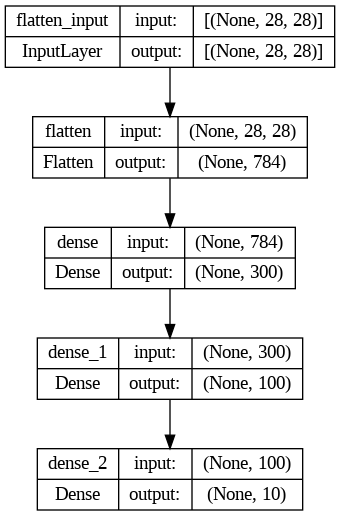

In [71]:
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

**Note:** This is more useful when the network topology is non-sequential.

In [72]:
model.layers

In [73]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [74]:
model.get_layer("dense") is hidden1

True

**Note:** The Python `is` keyword can be used to check if two variables refer to the same (mutable) object in memory. It should not be used to compare (immutable) literals. For comparing literals, use the `==` operator.

In [75]:
weights, biases = hidden1.get_weights()
type(weights), type(biases)

(numpy.ndarray, numpy.ndarray)

**Note:** As of now, the layer's weights & biases are just plain NumPy arrays, not tensors!

In [76]:
weights

array([[ 0.07044195, -0.06954394, -0.04374761, ..., -0.01674856,
        -0.06641558,  0.06231011],
       [-0.06550904,  0.05161111, -0.00468125, ..., -0.03035904,
        -0.0500112 , -0.06570468],
       [ 0.0484575 ,  0.03551996,  0.02840735, ...,  0.03199354,
        -0.01591474,  0.07159594],
       ...,
       [ 0.01832258, -0.05634034,  0.06999919, ..., -0.03756705,
        -0.06917683,  0.0160609 ],
       [-0.00202701,  0.05014023,  0.05823368, ..., -0.04320301,
        -0.07256585,  0.01319345],
       [-0.02932449,  0.06548482, -0.0168764 , ...,  0.06115963,
        -0.05070252, -0.04794054]], dtype=float32)

In [77]:
weights.shape

(784, 300)

In [78]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [79]:
biases.shape

(300,)

#### Compiling the model

In [80]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

This is equivalent to:

In [81]:
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.SGD(),
    metrics=[tf.keras.metrics.sparse_categorical_accuracy]
)

In [82]:
# Extra code - shows how to convert class ids to one-hot vectors:
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Note: It's important to set `num_classes` when the number of classes is greater than the maximum class ID in the batch.

In [83]:
# Extra code – shows how to convert one-hot vectors to class IDs:
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0])

#### Training and evaluating the model

In [84]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7111 - sparse_categorical_accuracy: 0.7660 - val_loss: 0.4987 - val_sparse_categorical_accuracy: 0.8266
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4842 - sparse_categorical_accuracy: 0.8324 - val_loss: 0.4562 - val_sparse_categorical_accuracy: 0.8398
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4395 - sparse_categorical_accuracy: 0.8459 - val_loss: 0.4214 - val_sparse_categorical_accuracy: 0.8544
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4156 - sparse_categorical_accuracy: 0.8553 - val_loss: 0.3937 - val_sparse_categorical_accuracy: 0.8620
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3949 - sparse_categorical_accuracy: 0.8607 - val_loss: 0.3890 - val_sparse_categorical_accuracy: 0.8620
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3783 - spars

In [85]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [86]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [87]:
type(history.history)

dict

In [88]:
for key, value in history.history.items():
    print(f"{key}: {value}")

loss: [0.7111420631408691, 0.4841860830783844, 0.4395125210285187, 0.4155799150466919, 0.39491015672683716, 0.37833172082901, 0.3659338057041168, 0.3542795181274414, 0.34367790818214417, 0.33386924862861633, 0.3253656029701233, 0.3177446722984314, 0.31057435274124146, 0.303582102060318, 0.2975353002548218, 0.2905258238315582, 0.2855994403362274, 0.27921298146247864, 0.2741885185241699, 0.26950740814208984, 0.26417994499206543, 0.2589820921421051, 0.2547871172428131, 0.249606192111969, 0.2453763633966446, 0.24160164594650269, 0.2361207753419876, 0.23335619270801544, 0.22955559194087982, 0.22582043707370758]
sparse_categorical_accuracy: [0.765999972820282, 0.8323818445205688, 0.8458908796310425, 0.8552727103233337, 0.8607454299926758, 0.8677091002464294, 0.8701454401016235, 0.8746181726455688, 0.8788909316062927, 0.8808545470237732, 0.8836363554000854, 0.8859999775886536, 0.8890727162361145, 0.8906000256538391, 0.8936908841133118, 0.8961091041564941, 0.8966000080108643, 0.898981809616088

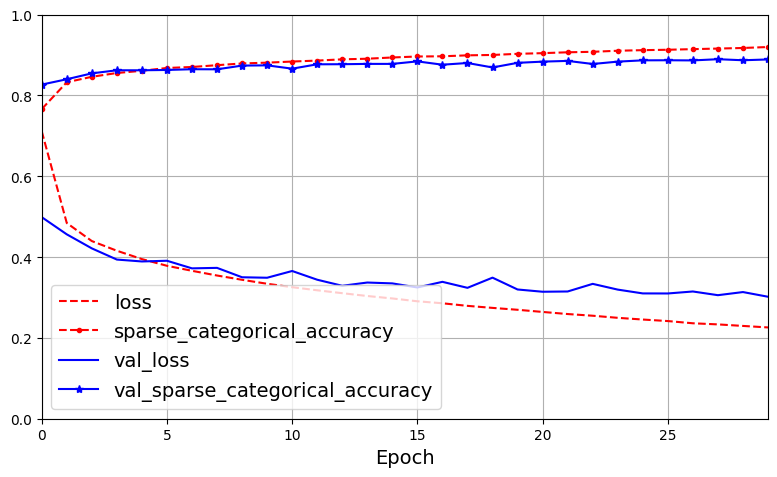

In [89]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"]
)
plt.legend(loc="lower left")
save_fig("keras_learning_curves_plot")
plt.show()

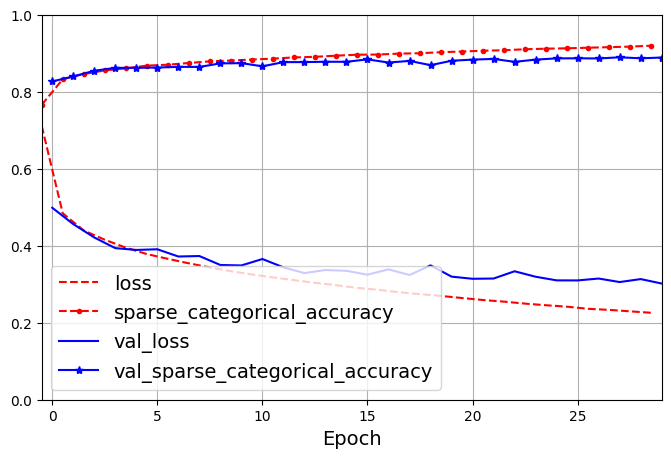

In [90]:
# Extra code – shows how to shift the training curves ('loss' and 'sparse_categorical_accuracy') by -1/2 epoch.
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [91]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3209 - sparse_categorical_accuracy: 0.8877


[0.3208669126033783, 0.8877000212669373]

#### Using the model to make predictions

In [92]:
X_new = X_test[:3]
X_new.shape

(3, 28, 28)

In [93]:
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 71ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

**Note:** We obtain softmax probabilities, not logits. This is because the softmax activation function was applied in the output layer.

In [94]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [95]:
# Exploratory:
np.array(class_names)

array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
       'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], dtype='<U11')

In [96]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

**Note:** Multiple indexing is possible with NumPy arrays. With lists, multiple isn't possible; we have to use either slices or list comprehensions.

In [97]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

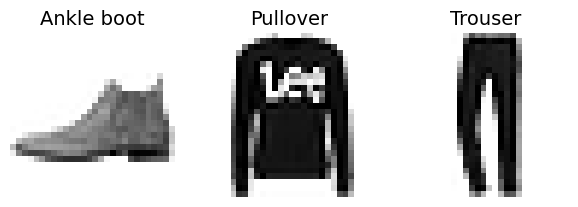

In [98]:
# Extra code – this cell generates and saves Figure 10–12.
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

**Note:** We completed the whole exercise without explicitly having to use `tf.Tensor`.

### Building a Regression MLP Using the Sequential API

Let's load and split the California housing dataset (the original one, not the modified one as in Chapter 2).

In [99]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing['data'], housing['target'], test_size=0.25, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((11610, 8), (3870, 8), (5160, 8), (11610,), (3870,), (5160,))

**Note:** We're fetching the dataset from scikit-learn, not TensorFlow.

In [100]:
X_train.shape[1]

8

In [101]:
X_train.shape[1:]

(8,)

**Note:** The `input_shape` argument needs to exclude the batch dimension. After excluding the batch dimension, we get a rank 1 array (i.e., a vector) of length 8, which is specified in NumPy as `(8,)`.

In [102]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
norm_layer

In [103]:
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 8)                 17        
 on)                                                             
                                                                 
 dense_3 (Dense)             (None, 50)                450       
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5618 (21.95 KB)
Trainable params: 5601 (21.88 KB)
Non-trainable params: 17 (72.00 Byte)
__________________

In [104]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

In [105]:
params = norm_layer.get_weights()
params

[array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 0]

In [106]:
norm_layer.adapt(X_train)

In [107]:
params = norm_layer.get_weights()
params

[array([ 3.8917589e+00,  2.8624548e+01,  5.4559393e+00,  1.0996356e+00,
         1.4242802e+03,  2.9588675e+00,  3.5646439e+01, -1.1958442e+02],
       dtype=float32),
 array([3.6453257e+00, 1.5979272e+02, 6.5044355e+00, 2.1665320e-01,
        1.2006890e+06, 5.5761123e+00, 4.5563760e+00, 4.0037255e+00],
       dtype=float32),
 11610]

In [108]:
params[0].shape, params[1].shape

((8,), (8,))

In [109]:
type(params[2])

numpy.int64

In [110]:
len(X_train)

11610

In [111]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 2s 2ms/step - loss: 0.8690 - root_mean_squared_error: 0.9322 - val_loss: 0.3835 - val_root_mean_squared_error: 0.6193
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3729 - root_mean_squared_error: 0.6107 - val_loss: 2.6406 - val_root_mean_squared_error: 1.6250
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3736 - root_mean_squared_error: 0.6113 - val_loss: 0.3303 - val_root_mean_squared_error: 0.5748
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3473 - root_mean_squared_error: 0.5893 - val_loss: 2.2354 - val_root_mean_squared_error: 1.4951
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3413 - root_mean_squared_error: 0.5842 - val_loss: 5.6318 - val_root_mean_squared_error: 2.3731
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3724 - root_mean_squared_error: 0.6103 - val_loss: 0.4908 - val_

In [112]:
mse_test, rmse_test = model.evaluate(X_test, y_test)
mse_test, rmse_test

162/162 [==============================] - 0s 1ms/step - loss: 0.2835 - root_mean_squared_error: 0.5325


(0.28353267908096313, 0.532477855682373)

In [113]:
X_new = X_test[:3]
X_new.shape

(3, 8)

In [114]:
y_pred = model.predict(X_new)
y_pred

1/1 [==============================] - 0s 67ms/step


array([[0.56400806],
       [1.0620344 ],
       [5.278493  ]], dtype=float32)

In [115]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

### Building Complex Models Using the Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

From the <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate" target="_blank">documentation</a> of `tf.keras.layers.Concatenate`:

> Concatenates a list of inputs.

> It takes as input a list of tensors, all of the same shape except for the concatenation axis, and returns a single tensor that is the concatenation of all inputs.

```
tf.keras.layers.Concatenate(
    axis=-1, **kwargs
)
```

---

Deviation:

In [116]:
def my_func(x, **kwargs):
    print(x)
    print(kwargs)

In [117]:
my_func(2)

2
{}


In [118]:
my_func(2, letter='a', boolean=True)

2
{'letter': 'a', 'boolean': True}


---

Example of usage of `tf.keras.layers.Concatenate`:

In [119]:
x = np.arange(20).reshape(2, 2, 5)
y = np.arange(20, 30).reshape(2, 1, 5)
concat_output = tf.keras.layers.Concatenate(axis=1)([x, y])
type(concat_output)

tensorflow.python.framework.ops.EagerTensor

In [120]:
concat_output.shape

TensorShape([2, 3, 5])

---

PyTorch equivalent:

In [121]:
import torch

torch.arange(20)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])

In [122]:
x = torch.arange(20).view(2, 2, 5)
x.shape

torch.Size([2, 2, 5])

In [123]:
y = torch.arange(20, 30).view(2, 1, 5)
y.shape

torch.Size([2, 1, 5])

In [124]:
concat_output = torch.cat([x, y], axis=1)
concat_output

tensor([[[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9],
         [20, 21, 22, 23, 24]],

        [[10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19],
         [25, 26, 27, 28, 29]]])

---

In [125]:
tf.keras.layers.Input(shape=X_train.shape[1:])

<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'input_1')>

In [126]:
# Alt:
tf.keras.Input(shape=X_train.shape[1:])

<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'input_2')>

**Note:** This is not the same as `tf.keras.layers.InputLayer`, which was used in our first sequential Fashion-MNIST model.

From the book:

> Next, we create an `Input` object. This is a specification of the kind of input the model will get, including its `shape` and optionally its `dtype`, which defaults to 32-bit floats.

> The `Input` object is just a data specification.

The `Input` object is a symbolic object. It is what allows the functional API to work. You can think of it in a similar manner to the `x` parameter of the `forward` method in PyTorch.

If instead of passing a symbolic `Input` object to the first layer, you pass a NumPy array, then you'll get back an `EagerTensor`.

In [127]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [128]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 normalization (Normalizati  (None, 8)                    17        ['input_1[0][0]']             
 on)                                                                                              
                                                                                                  
 dense (Dense)               (None, 30)                   270       ['normalization[0][0]']       
                                                                                                  
 dense_1 (Dense)             (None, 30)                   930       ['dense[0][0]']           

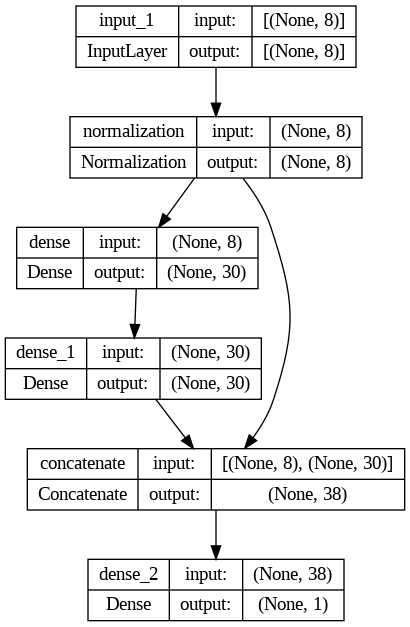

In [129]:
tf.keras.utils.plot_model(model, "wide_and_deep.png", show_shapes=True)

In [130]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

In [131]:
normalization_layer.adapt(X_train)

In [132]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.3904 - root_mean_squared_error: 1.1792 - val_loss: 0.8104 - val_root_mean_squared_error: 0.9002
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4547 - root_mean_squared_error: 0.6743 - val_loss: 0.8192 - val_root_mean_squared_error: 0.9051
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3942 - root_mean_squared_error: 0.6279 - val_loss: 0.4196 - val_root_mean_squared_error: 0.6478
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3679 - root_mean_squared_error: 0.6066 - val_loss: 0.4604 - val_root_mean_squared_error: 0.6785
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3607 - root_mean_squared_error: 0.6006 - val_loss: 1.2125 - val_root_mean_squared_error: 1.1011
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3546 - root_mean_squared_error: 0.5955 - val_loss: 1.7785 - val_

In [133]:
mse_test, rmse_test = model.evaluate(X_test, y_test)
mse_test, rmse_test

162/162 [==============================] - 0s 986us/step - loss: 0.3024 - root_mean_squared_error: 0.5499


(0.30241671204566956, 0.5499242544174194)

In [134]:
y_pred = model.predict(X_new)
y_pred

1/1 [==============================] - 0s 49ms/step


array([[0.37979102],
       [1.2868782 ],
       [4.525299  ]], dtype=float32)

In [135]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

What if you want to send different subsets of input features through the wide and deep paths? We will send 5 features (features 0 to 4) through the wide path, and 6 features (features 2 to 7) through the deep path. Note that 3 features (features 2, 3 and 4) will go through both paths.

In [136]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [137]:
input_wide = tf.keras.Input(shape=[5]) # features 0 to 4
input_deep = tf.keras.Input(shape=[6]) # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [138]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 normalization_1 (Normaliza  (None, 6)                    13        ['input_2[0][0]']             
 tion)                                                                                            
                                                                                                  
 input_1 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 30)                   210       ['normalization_1[0][0]'] 

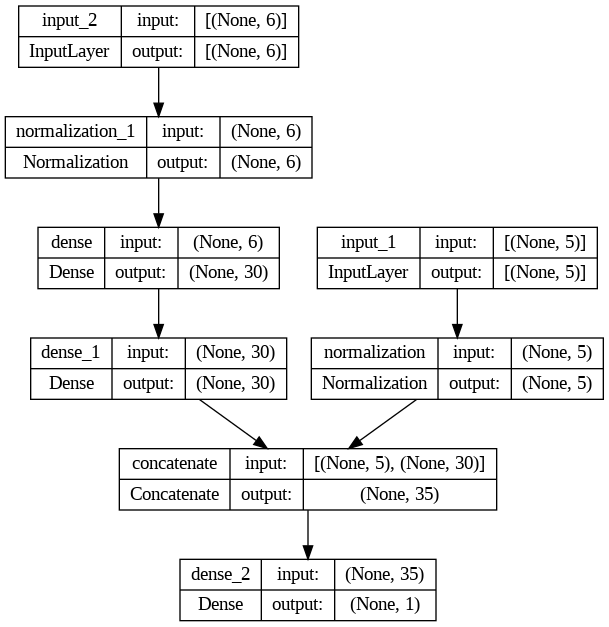

In [139]:
tf.keras.utils.plot_model(model, "wide_and_deep_multiple_inputs.png", show_shapes=True)

**Note:** `tf.keras.layers.concatenate` is the functional version of `tf.keras.layers.Concatenate`.

**Question:** How can multiple inputs be implemented in PyTorch? Let's say `x` is the argument to the `forward` method. Either `x` can be a tensor, and we can slice it to get multiple inputs. Or `x` can be a dictionary comprising multiple inputs (e.g., `'input_ids'` and `'attention_mask'` in DistilBERT). The latter might be preferable.

In [140]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

In [141]:
X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

In [142]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)

In [143]:
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20, validation_data=((X_valid_wide, X_valid_deep), y_valid))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.9513 - root_mean_squared_error: 1.3969 - val_loss: 0.8654 - val_root_mean_squared_error: 0.9303
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6572 - root_mean_squared_error: 0.8106 - val_loss: 0.7091 - val_root_mean_squared_error: 0.8421
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5221 - root_mean_squared_error: 0.7225 - val_loss: 0.4626 - val_root_mean_squared_error: 0.6802
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4583 - root_mean_squared_error: 0.6769 - val_loss: 0.5156 - val_root_mean_squared_error: 0.7180
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4178 - root_mean_squared_error: 0.6464 - val_loss: 0.7711 - val_root_mean_squared_error: 0.8781
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3951 - root_mean_squared_error: 0.6285 - val_loss: 0.6924 - val_

In [144]:
mse_test, rmse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
mse_test, rmse_test

162/162 [==============================] - 0s 1ms/step - loss: 0.3216 - root_mean_squared_error: 0.5671


(0.32164454460144043, 0.5671371221542358)

In [145]:
y_pred = model.predict((X_new_wide, X_new_deep))
y_pred

1/1 [==============================] - 0s 57ms/step


array([[0.35445172],
       [1.1565343 ],
       [3.4437582 ]], dtype=float32)

In [146]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

Adding an auxiliary output for regularization:

In [147]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [148]:
input_wide = tf.keras.Input(shape=[5]) # features 0 to 4
input_deep = tf.keras.Input(shape=[6]) # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output, aux_output])

In [149]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 normalization_1 (Normaliza  (None, 6)                    13        ['input_2[0][0]']             
 tion)                                                                                            
                                                                                                  
 input_1 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 30)                   210       ['normalization_1[0][0]'] 

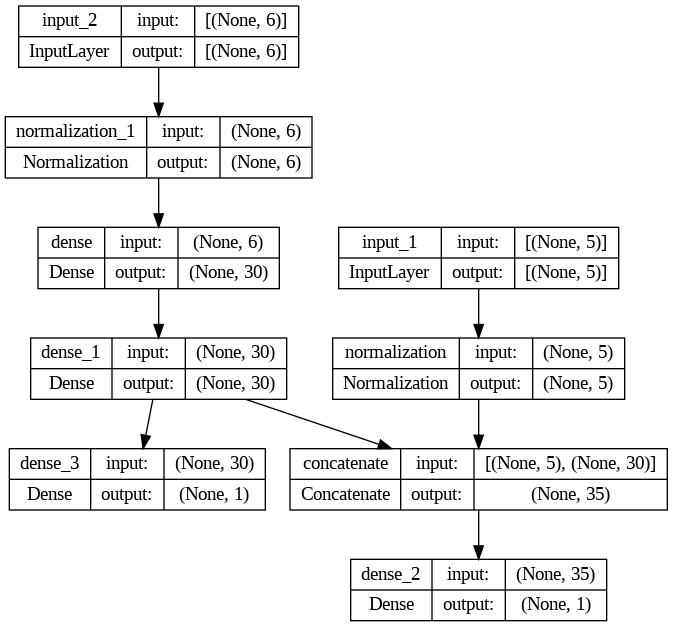

In [150]:
tf.keras.utils.plot_model(model, "wide_and_deep_aux_output.png", show_shapes=True)

In [151]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer, metrics=["RootMeanSquaredError"])

**Note:** Here, the metric function for `output` and `aux_output` is the same. But in case `output` and `aux_output` need to be evaluated on different metric functions, you can specify a list of different metrics in the above line.

In [152]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), (y_train, y_train), epochs=20, validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))

Epoch 1/20
363/363 [==============================] - 2s 2ms/step - loss: 1.9704 - dense_2_loss: 1.9476 - dense_3_loss: 2.1757 - dense_2_root_mean_squared_error: 1.3956 - dense_3_root_mean_squared_error: 1.4750 - val_loss: 1.5093 - val_dense_2_loss: 1.0427 - val_dense_3_loss: 5.7089 - val_dense_2_root_mean_squared_error: 1.0211 - val_dense_3_root_mean_squared_error: 2.3893
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6464 - dense_2_loss: 0.6222 - dense_3_loss: 0.8643 - dense_2_root_mean_squared_error: 0.7888 - dense_3_root_mean_squared_error: 0.9297 - val_loss: 1.2871 - val_dense_2_loss: 1.0404 - val_dense_3_loss: 3.5077 - val_dense_2_root_mean_squared_error: 1.0200 - val_dense_3_root_mean_squared_error: 1.8729
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5241 - dense_2_loss: 0.5097 - dense_3_loss: 0.6529 - dense_2_root_mean_squared_error: 0.7140 - dense_3_root_mean_squared_error: 0.8080 - val_loss: 0.7987 - val_dense_2_loss

In [153]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse

162/162 [==============================] - 0s 1ms/step - loss: 0.3343 - dense_2_loss: 0.3279 - dense_3_loss: 0.3917 - dense_2_root_mean_squared_error: 0.5726 - dense_3_root_mean_squared_error: 0.6259


(0.3342781364917755,
 0.3278951942920685,
 0.3917243480682373,
 0.5726213455200195,
 0.6258788704872131)

In [154]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))
y_pred_main, y_pred_aux

1/1 [==============================] - 0s 63ms/step


(array([[0.54366046],
        [0.9974929 ],
        [3.4874165 ]], dtype=float32),
 array([[0.76353353],
        [0.796178  ],
        [3.2012148 ]], dtype=float32))

**Question:** Is it possible for a PyTorch model to return a dictionary of tensors as outputs? It might be possible with slicing. Experiment! Alternatively, try returning a `CustomModelOutput` object containing multiple attributes (including `loss` if the labels are provided). This is what models in HF Transformers do.

In [155]:
model.output_names

['dense_2', 'dense_3']

In [156]:
y_pred_list = model.predict((X_new_wide, X_new_deep))
y_pred_list

1/1 [==============================] - 0s 16ms/step


[array([[0.54366046],
        [0.9974929 ],
        [3.4874165 ]], dtype=float32),
 array([[0.76353353],
        [0.796178  ],
        [3.2012148 ]], dtype=float32)]

In [157]:
y_pred = dict(zip(model.output_names, y_pred_list))
y_pred

{'dense_2': array([[0.54366046],
        [0.9974929 ],
        [3.4874165 ]], dtype=float32),
 'dense_3': array([[0.76353353],
        [0.796178  ],
        [3.2012148 ]], dtype=float32)}

### Using the Subclassing API to Build Dynamic Models

> Some models involve loops, varying shapes, conditional branching, and other dynamic behaviors.

**Question:** The above sentence is referring to loops in the `forward` method (ala fast.ai 2020 Lesson 8), not loops in the constructor (ala `NetResDeep` in the "Deep Learning with PyTorch" book). But what about varying shapes, conditional branching, and other dynamic behaviors? What are some examples of these? Chapter 12 probably contains the answer to this question.

In [158]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) # Needed to support naming the model.
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(30, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(30, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)

    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

In [159]:
tf.random.set_seed(42)
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

**Note:** Unlike in PyTorch, the model weights aren't instantiated until the model is built. Moreover, the model summary can't be displayed.

In [160]:
try:
    model.summary()
except ValueError as e:
    print(e)

This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.


In [161]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer, metrics=["RootMeanSquaredError"])

**Note:** Even after running the above code cell, the model is still not built. (It has no idea what the input shape is.) This issue is not there in PyTorch because each layer explicitly specifies `in_features` / `in_channels` / etc.

In [162]:
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), (y_train, y_train), epochs=10, validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))

Epoch 1/10
363/363 [==============================] - 2s 2ms/step - loss: 1.7610 - output_1_loss: 1.7578 - output_2_loss: 1.7893 - output_1_root_mean_squared_error: 1.3258 - output_2_root_mean_squared_error: 1.3376 - val_loss: 6.0978 - val_output_1_loss: 5.2261 - val_output_2_loss: 13.9438 - val_output_1_root_mean_squared_error: 2.2861 - val_output_2_root_mean_squared_error: 3.7341
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6792 - output_1_loss: 0.6700 - output_2_loss: 0.7626 - output_1_root_mean_squared_error: 0.8185 - output_2_root_mean_squared_error: 0.8733 - val_loss: 3.0416 - val_output_1_loss: 2.4053 - val_output_2_loss: 8.7676 - val_output_1_root_mean_squared_error: 1.5509 - val_output_2_root_mean_squared_error: 2.9610
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5460 - output_1_loss: 0.5369 - output_2_loss: 0.6286 - output_1_root_mean_squared_error: 0.7327 - output_2_root_mean_squared_error: 0.7928 - val_loss: 1.34

In [163]:
model.summary()

Model: "my_cool_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normaliza  multiple                  11        
 tion)                                                           
                                                                 
 normalization_3 (Normaliza  multiple                  13        
 tion)                                                           
                                                                 
 dense_4 (Dense)             multiple                  210       
                                                                 
 dense_5 (Dense)             multiple                  930       
                                                                 
 dense_6 (Dense)             multiple                  36        
                                                                 
 dense_7 (Dense)             multiple                

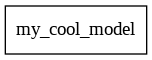

In [164]:
tf.keras.utils.plot_model(model, "dynamic.png", show_shapes=True)

In [165]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse

162/162 [==============================] - 0s 1ms/step - loss: 0.3588 - output_1_loss: 0.3481 - output_2_loss: 0.4550 - output_1_root_mean_squared_error: 0.5900 - output_2_root_mean_squared_error: 0.6746


(0.3587728440761566,
 0.34807711839675903,
 0.455034464597702,
 0.5899806022644043,
 0.6745624542236328)

In [166]:
y_pred_main, y_pred_aux = model.predict([X_new_wide, X_new_deep])
y_pred_main, y_pred_aux

1/1 [==============================] - 0s 66ms/step


(array([[0.3065114],
        [1.4568672],
        [3.4570036]], dtype=float32),
 array([[0.53806823],
        [1.6467695 ],
        [3.031021  ]], dtype=float32))

### Saving and Restoring a Model

In [ ]:
# extra code – delete the directory, in case it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

In [ ]:
model.save("my_keras_model", save_format="tf")

In [ ]:
# extra code – show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

In [ ]:
model = tf.keras.models.load_model("my_keras_model")
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

In [ ]:
model.save_weights("my_weights")

In [ ]:
model.load_weights("my_weights")

In [ ]:
# extra code – show the list of my_weights.* files
for path in sorted(Path().glob("my_weights.*")):
    print(path)

### Using Callbacks

In [ ]:
shutil.rmtree("my_checkpoints", ignore_errors=True)  # extra code

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

In [ ]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [ ]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

### Using TensorBoard for Visualization

TensorBoard is preinstalled on Colab, but not the `tensorboard-plugin-profile`, so let's install it:

In [ ]:
if "google.colab" in sys.modules:  # extra code
    %pip install -q -U tensorboard-plugin-profile

In [ ]:
shutil.rmtree("my_logs", ignore_errors=True)

In [ ]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [ ]:
# extra code – builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [ ]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

In [ ]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

Let's load the `tensorboard` Jupyter extension and start the TensorBoard server:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

**Note**: if you prefer to access TensorBoard in a separate tab, click the "localhost:6006" link below:

In [ ]:
# extra code

if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

You can use also visualize histograms, images, text, and even listen to audio using TensorBoard:

In [ ]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)

        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)

        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)

        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)

        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

**Note**: it used to be possible to easily share your TensorBoard logs with the world by uploading them to https://tensorboard.dev/. Sadly, this service will shut down in December 2023, so I have removed the corresponding code examples from this notebook.

When you stop this Jupyter kernel (a.k.a. Runtime), it will automatically stop the TensorBoard server as well. Another way to stop the TensorBoard server is to kill it, if you are running on Linux or MacOSX. First, you need to find its process ID:

In [ ]:
# extra code – lists all running TensorBoard server instances

from tensorboard import notebook

notebook.list()

Next you can use the following command on Linux or MacOSX, replacing `<pid>` with the pid listed above:

    !kill <pid>

On Windows:

    !taskkill /F /PID <pid>

## Fine-Tuning Neural Network Hyperparameters

In this section we'll use the Fashion MNIST dataset again:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner

In [ ]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [ ]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

In [ ]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [ ]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

In [ ]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

In [ ]:
best_trial.metrics.get_last_value("val_accuracy")

In [ ]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

In [ ]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [ ]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [ ]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

In [ ]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

In [ ]:
%tensorboard --logdir {root_logdir}

## Exercise Solutions

### 1 to 9

1. Visit the [TensorFlow Playground](https://playground.tensorflow.org/) and play around with it, as described in this exercise.
2. Here is a neural network based on the original artificial neurons that computes _A_ ⊕ _B_ (where ⊕ represents the exclusive OR), using the fact that _A_ ⊕ _B_ = (_A_ ∧ ¬ _B_) ∨ (¬ _A_ ∧ _B_). There are other solutions—for example, using the fact that _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ ¬(_A_ ∧ _B_), or the fact that _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ (¬ _A_ ∨ ¬ _B_), and so on.<br /><img width="70%" src="images/ann/exercise2.png" />
3. A classical Perceptron will converge only if the dataset is linearly separable, and it won't be able to estimate class probabilities. In contrast, a Logistic Regression classifier will generally converge to a reasonably good solution even if the dataset is not linearly separable, and it will output class probabilities. If you change the Perceptron's activation function to the sigmoid activation function (or the softmax activation function if there are multiple neurons), and if you train it using Gradient Descent (or some other optimization algorithm minimizing the cost function, typically cross entropy), then it becomes equivalent to a Logistic Regression classifier.
4. The sigmoid activation function was a key ingredient in training the first MLPs because its derivative is always nonzero, so Gradient Descent can always roll down the slope. When the activation function is a step function, Gradient Descent cannot move, as there is no slope at all.
5. Popular activation functions include the step function, the sigmoid function, the hyperbolic tangent (tanh) function, and the Rectified Linear Unit (ReLU) function (see Figure 10-8). See Chapter 11 for other examples, such as ELU and variants of the ReLU function.
6. Considering the MLP described in the question, composed of one input layer with 10 passthrough neurons, followed by one hidden layer with 50 artificial neurons, and finally one output layer with 3 artificial neurons, where all artificial neurons use the ReLU activation function:
    * The shape of the input matrix **X** is _m_ × 10, where _m_ represents the training batch size.
    * The shape of the hidden layer's weight matrix **W**<sub>_h_</sub> is 10 × 50, and the length of its bias vector **b**<sub>_h_</sub> is 50.
    * The shape of the output layer's weight matrix **W**<sub>_o_</sub> is 50 × 3, and the length of its bias vector **b**<sub>_o_</sub> is 3.
    * The shape of the network's output matrix **Y** is _m_ × 3.
    * **Y** = ReLU(ReLU(**X** **W**<sub>_h_</sub> + **b**<sub>_h_</sub>) **W**<sub>_o_</sub> + **b**<sub>_o_</sub>). Recall that the ReLU function just sets every negative number in the matrix to zero. Also note that when you are adding a bias vector to a matrix, it is added to every single row in the matrix, which is called _broadcasting_.
7. To classify email into spam or ham, you just need one neuron in the output layer of a neural network—for example, indicating the probability that the email is spam. You would typically use the sigmoid activation function in the output layer when estimating a probability. If instead you want to tackle MNIST, you need 10 neurons in the output layer, and you must replace the sigmoid function with the softmax activation function, which can handle multiple classes, outputting one probability per class. If you want your neural network to predict housing prices like in Chapter 2, then you need one output neuron, using no activation function at all in the output layer. Note: when the values to predict can vary by many orders of magnitude, you may want to predict the logarithm of the target value rather than the target value directly. Simply computing the exponential of the neural network's output will give you the estimated value (since exp(log _v_) = _v_).
8. Backpropagation is a technique used to train artificial neural networks. It first computes the gradients of the cost function with regard to every model parameter (all the weights and biases), then it performs a Gradient Descent step using these gradients. This backpropagation step is typically performed thousands or millions of times, using many training batches, until the model parameters converge to values that (hopefully) minimize the cost function. To compute the gradients, backpropagation uses reverse-mode autodiff (although it wasn't called that when backpropagation was invented, and it has been reinvented several times). Reverse-mode autodiff performs a forward pass through a computation graph, computing every node's value for the current training batch, and then it performs a reverse pass, computing all the gradients at once (see Appendix B for more details). So what's the difference? Well, backpropagation refers to the whole process of training an artificial neural network using multiple backpropagation steps, each of which computes gradients and uses them to perform a Gradient Descent step. In contrast, reverse-mode autodiff is just a technique to compute gradients efficiently, and it happens to be used by backpropagation.
9. Here is a list of all the hyperparameters you can tweak in a basic MLP: the number of hidden layers, the number of neurons in each hidden layer, and the activation function used in each hidden layer and in the output layer. In general, the ReLU activation function (or one of its variants; see Chapter 11) is a good default for the hidden layers. For the output layer, in general you will want the sigmoid activation function for binary classification, the softmax activation function for multiclass classification, or no activation function for regression. If the MLP overfits the training data, you can try reducing the number of hidden layers and reducing the number of neurons per hidden layer.

### 10

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `tf.keras.datasets.mnist.load_data()`. See if you can get over 98% accuracy by manually tuning the hyperparameters. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Next, try tuning the hyperparameters using Keras Tuner with all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

**TODO**: update this solution to use Keras Tuner.

Let's load the dataset:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [ ]:
X_train_full.shape

Each pixel intensity is also represented as a byte (0 to 255):

In [ ]:
X_train_full.dtype

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [ ]:
y_train

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [ ]:
X_valid.shape

In [ ]:
X_test.shape

Let's take a look at a sample of the images in the dataset:

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [ ]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [ ]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

We can now plot the loss as a functionof the learning rate:

In [ ]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
run_index = 1 # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

In [ ]:
model = tf.keras.models.load_model("my_mnist_model") # rollback to best model
model.evaluate(X_test, y_test)

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [ ]:
%tensorboard --logdir=./my_mnist_logs